# Analyse Customer Behaviour in a Multi Category e-Commerce Website
The dataset contains customer behaviour data of a large multi category e-commerce website. The customer behaviour is reflected in the `event_type` field which is either view, cart or purchase. Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users. This exercise uses the 2019 October dataset published in Kaggle https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store. The dataset originally collected from Open CDP https://rees46.com/en/open-cdp. 

The selected dataset is approximately 5Gb in volume which makes data processing a difficult in our usual RStudio or Colab environment. Therefore, we need to move into a big data technology to process this dataset. In this exercise, we run the exerecise in a Hadoop with Hive cluster run on a Cloud environment. We use Jupyter Notebook as our IDE and connect to the Hive cluster using Python (`pyhive`) which submits remote hive queries through hiveserver2. The exercise first connect to the hiveserver, extract the data which is stored in HDFS and then run several descriptive analytics to understand the customer behaviour.

## 1. Connect to Hiveserver using `pyhive`
`pyhive` package uses `connect` function to create a JDBC connection with a hiveserver. This connection then can be used to send hive queries to the hiveserver.

In [1]:
! pip install pyhive impyla hdfs
from pyhive import hive
from impala.dbapi import connect #impyla
from hdfs import InsecureClient
conn = connect(host='hive-server', port='10000', auth_mechanism='PLAIN')
cursor=conn.cursor()
cursor

## 2. Create Hive External Table Using HDFS Data
Hive external table are used to read data from a file system such as HDFS. Hive external tables do not store data. It creates a schema with a reference to the file system. External tables are stored outside the warehouse directory. They can access data stored in sources such as remote HDFS locations.

EXTERNAL keyword is used in the Hive create table. If the external table is dropped, it only deletes the schema created and related metadata. This does not delete the source datafile.

In [42]:
cursor.execute("CREATE EXTERNAL TABLE IF NOT EXISTS customer_behaviour(event_time STRING, event_type STRING, \
              product_id INT, category_id STRING, category_code STRING, brand STRING,price FLOAT, \
              user_id INT, user_session STRING) \
              ROW FORMAT DELIMITED \
              FIELDS TERMINATED BY ',' \
              LINES TERMINATED BY '\n' \
              LOCATION 'hdfs://hadoop-hadoop-hdfs-nn:9000/user/hive' \
              TBLPROPERTIES('skip.header.line.count'='1')")  

In [43]:
cursor.execute("SHOW TABLES")
for item in cursor.fetchall():
    print(item)

('customer_behaviour',)


## 3. Check the Data Table
`pyhive` allows hive queries to be sent to the hiveserver. Hiverserver then executes the query and return the result. `fetchall()` function is used to iterate through the result and print the output.

In [44]:
cursor.execute("SET hadoop.proxyuser.root.hosts=*") # run in hive 
cursor.execute("SET hadoop.proxyuser.root.groups=*")
cursor.execute("SET hive.exec.mode.local.auto=false")
cursor.execute("SET hive.execution.engine=mr")
cursor.execute("SET mapreduce.framework.name=yarn")

In [45]:
cursor.execute("SELECT * FROM customer_behaviour LIMIT 10")
for item in cursor.fetchall():
    print(item)

('2019-10-01 00:00:00 UTC', 'view', 44600062, '2103807459595387724', '', 'shiseido', 35.79, 541312140, '72d76fde-8bb3-4e00-8c23-a032dfed738c')
('2019-10-01 00:00:00 UTC', 'view', 3900821, '2053013552326770905', 'appliances.environment.water_heater', 'aqua', 33.2, 554748717, '9333dfbd-b87a-4708-9857-6336556b0fcc')
('2019-10-01 00:00:01 UTC', 'view', 17200506, '2053013559792632471', 'furniture.living_room.sofa', '', 543.1, 519107250, '566511c2-e2e3-422b-b695-cf8e6e792ca8')
('2019-10-01 00:00:01 UTC', 'view', 1307067, '2053013558920217191', 'computers.notebook', 'lenovo', 251.74, 550050854, '7c90fc70-0e80-4590-96f3-13c02c18c713')
('2019-10-01 00:00:04 UTC', 'view', 1004237, '2053013555631882655', 'electronics.smartphone', 'apple', 1081.98, 535871217, 'c6bd7419-2748-4c56-95b4-8cec9ff8b80d')
('2019-10-01 00:00:05 UTC', 'view', 1480613, '2053013561092866779', 'computers.desktop', 'pulser', 908.62, 512742880, '0d0d91c2-c9c2-4e81-90a5-86594dec0db9')
('2019-10-01 00:00:08 UTC', 'view', 17300353

## 4. Run Hive Queries
Since Hiveserver can be considered as a SQL database, you can consider using `pandas` `read_sql` function with the hiveserver connection created with `pyhive`. 

Output of these queries return panda dataframe which can be processed and manipulated with pandas methods.

In [8]:
cursor.execute("SELECT event_type, count(*) FROM customer_behaviour GROUP BY event_type")
for item in cursor.fetchall():
    print(item)

('view', 40779399)
('cart', 926516)
('purchase', 742849)


In [10]:
import pandas as pd
event_type = pd.read_sql("SELECT event_type, count(*) FROM customer_behaviour GROUP BY event_type", conn)
event_type

/tmp/ipykernel_122/562490089.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  event_type = pd.read_sql("SELECT event_type, count(*) FROM customer_behaviour GROUP BY event_type", conn)


,event_type,_c1
0,view,40779399
1,cart,926516
2,purchase,742849


## Exercise 01
Using the hive external table, run the following queries.

    1. Total value of customer behaviour by event type.
    2. Top 10 brands purchased by value
    3. Top 10 brands purchased by volume

In [11]:
event_value = pd.read_sql("SELECT event_type, sum(price) as value FROM customer_behaviour GROUP BY event_type", conn)
event_value

/tmp/ipykernel_122/2493094891.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  event_value = pd.read_sql("SELECT event_type, sum(price) as value FROM customer_behaviour GROUP BY event_type", conn)


,event_type,value
0,view,1.178462e+10
1,cart,3.092988e+08
2,purchase,2.299575e+08


In [12]:
top_brands_by_value = pd.read_sql("SELECT brand, value FROM (SELECT brand, sum(price) AS value \
                                        FROM customer_behaviour \
                                        WHERE event_type = 'purchase' \
                                        GROUP BY brand) \
                                        customer_behaviour \
                                        ORDER BY value DESC LIMIT 10", conn)

top_brands_by_value

/tmp/ipykernel_122/3789693419.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  top_brands_by_value = pd.read_sql("SELECT brand, value FROM (SELECT brand, sum(price) AS value \


,brand,value
0,apple,1.112093e+08
1,samsung,4.640753e+07
2,xiaomi,9.194033e+06
3,,8.540601e+06
4,huawei,4.883422e+06
5,acer,3.576719e+06
6,lg,3.387888e+06
7,lucente,3.124113e+06
8,sony,2.478197e+06
9,oppo,2.412960e+06


In [13]:
top_brands_by_volume = pd.read_sql("SELECT brand, volume FROM (SELECT brand, count(product_id) AS volume \
                                        FROM customer_behaviour \
                                        WHERE event_type = 'purchase' \
                                        GROUP BY brand) \
                                        customer_behaviour \
                                        ORDER BY volume DESC LIMIT 10", conn)

top_brands_by_volume

/tmp/ipykernel_122/2378989288.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  top_brands_by_volume = pd.read_sql("SELECT brand, volume FROM (SELECT brand, count(product_id) AS volume \


,brand,volume
0,samsung,172896
1,apple,142873
2,,58214
3,xiaomi,56616
4,huawei,23501
5,lucente,11578
6,oppo,10891
7,cordiant,10551
8,lg,8727
9,acer,6882


## Exercise 02

The `category_code` variable includes the product category and sub-categories deliemeted by a `.`. Using a string manipulation, extract the following query results.

1. Extract the main category of the purchased items with the price
2. Total value and volume of purchased items by the main category
3. Top 10 product categories by value
4. Top 10 product categories by volume

In [14]:
categories = pd.read_sql("SELECT regexp_extract(category_code, '^([^\.]+)\.?', 1) AS category, product_id, price \
                            FROM customer_behaviour \
                            WHERE event_type = 'purchase'", conn)
categories

/tmp/ipykernel_122/1239111758.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  categories = pd.read_sql("SELECT regexp_extract(category_code, '^([^\.]+)\.?', 1) AS category, product_id, price \


,category,product_id,price
0,electronics,1004856,130.76
1,electronics,1002532,642.69
2,,5100816,29.51
3,furniture,13800054,54.42
4,electronics,4804055,189.91
...,...,...,...
742844,,26402784,102.45
742845,construction,47500017,20.59
742846,electronics,1003306,577.89
742847,electronics,1004240,1054.60


In [15]:
import numpy as np
category_master = categories.groupby('category').agg(Value=('price',np.sum), Volume=('product_id',np.count_nonzero))
category_master.head()

,Value,Volume
category,,
,22924937.13,173425
accessories,68783.88,1587
apparel,624937.75,8002
appliances,13583121.92,74996
auto,1274031.65,10620


In [16]:
category_master.sort_values(['Value'],ascending=[False]).head(10)

,Value,Volume
category,,
electronics,1.764642e+08,423028
,2.292494e+07,173425
appliances,1.358312e+07,74996
computers,1.137887e+07,27855
furniture,1.673729e+06,8301
auto,1.274032e+06,10620
construction,9.329950e+05,7801
kids,6.781407e+05,5482
apparel,6.249378e+05,8002


In [17]:
category_master.sort_values(['Volume'],ascending=[False]).head(10)

,Value,Volume
category,,
electronics,1.764642e+08,423028
,2.292494e+07,173425
appliances,1.358312e+07,74996
computers,1.137887e+07,27855
auto,1.274032e+06,10620
furniture,1.673729e+06,8301
apparel,6.249378e+05,8002
construction,9.329950e+05,7801
kids,6.781407e+05,5482


## Exercise 03
The dataset includes items viewed by the users. This can be identified using the `event_type`. The company wants to analyse the daily view pattern during the month. First we need to generate the date from the timestamp value. Then the company requires us to generate the following query results.

1. Create daily view pattern of apple products
2. Visualise the timeseries using a line chart
3. Compare the view patterns of apple vs samsung
4. Compare the two frequency distributions

In [18]:
apple_views = pd.read_sql("SELECT event_date, count(*) as volume FROM (SELECT TO_DATE(FROM_UTC_TIMESTAMP(event_time, 'UTC')) AS event_date, brand \
                    FROM customer_behaviour WHERE brand='apple') customer_behaviour GROUP BY \
                    event_date ORDER BY event_date", conn)

/tmp/ipykernel_122/606059231.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  apple_views = pd.read_sql("SELECT event_date, count(*) as volume FROM (SELECT TO_DATE(FROM_UTC_TIMESTAMP(event_time, 'UTC')) AS event_date, brand \


In [19]:
apple_views.head()

,event_date,volume
0,2019-10-01,128012
1,2019-10-02,124698
2,2019-10-03,124002
3,2019-10-04,159162
4,2019-10-05,142097


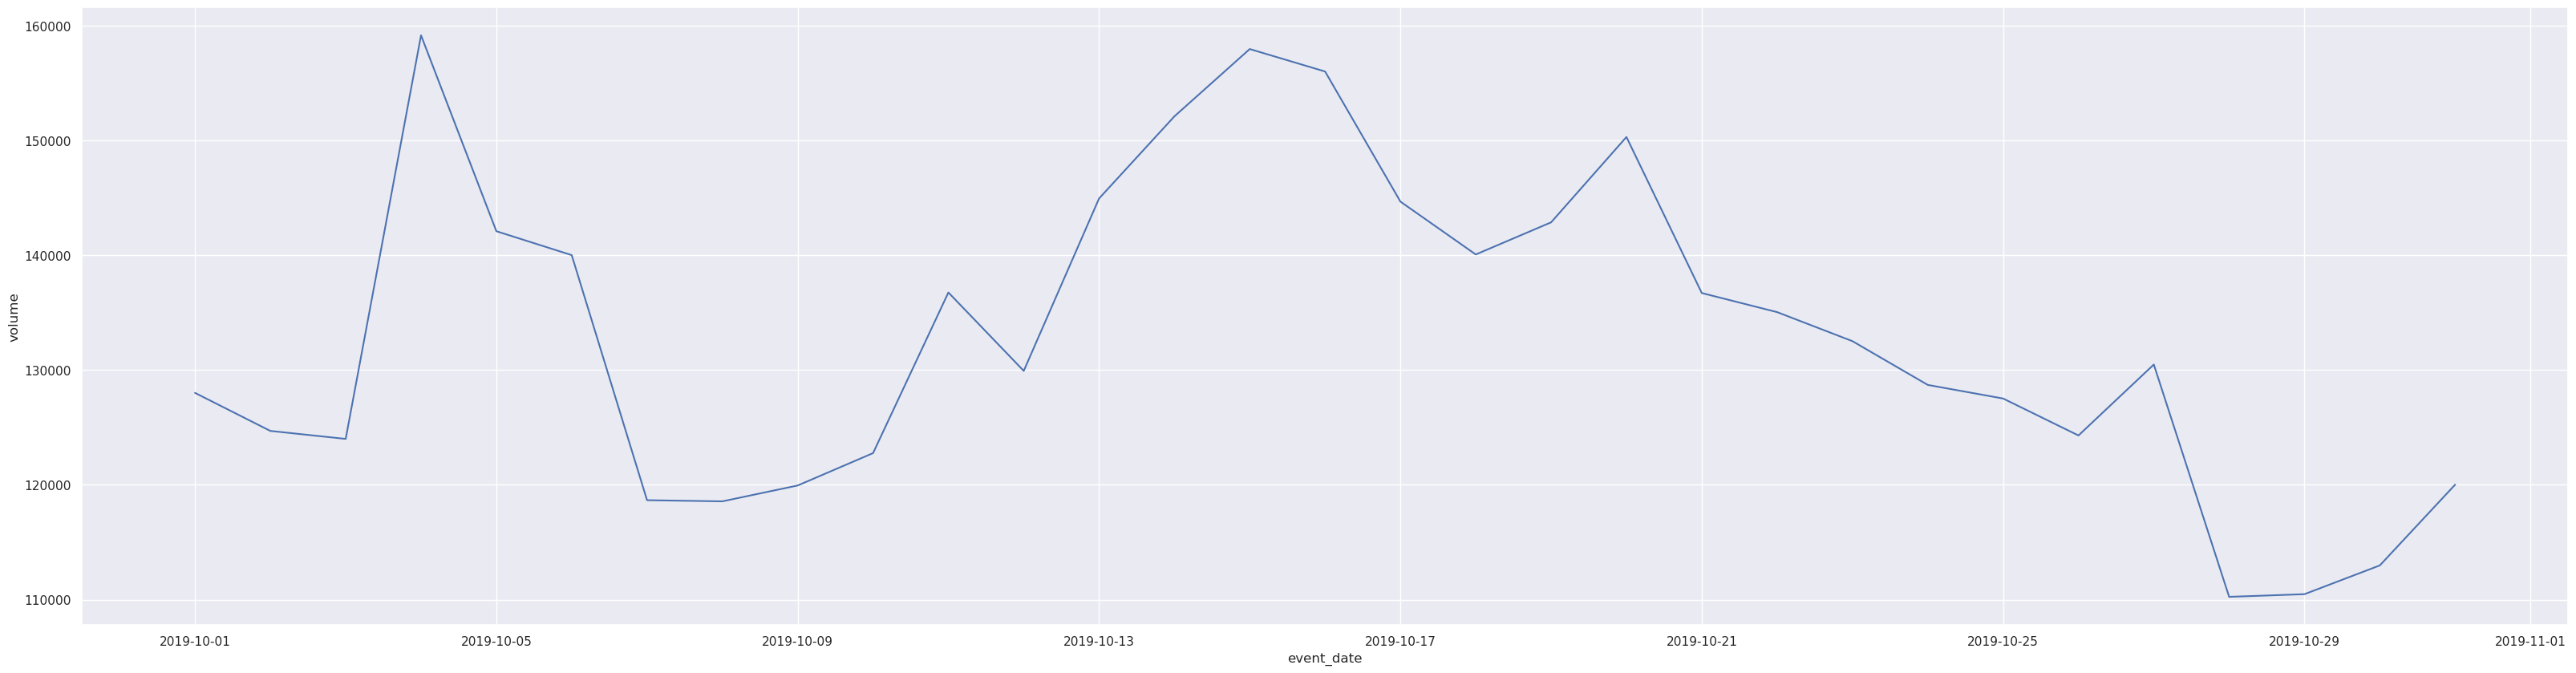

In [22]:
import seaborn as sns
sns.lineplot(apple_views,x="event_date",y="volume")
sns.set(rc={'figure.figsize':(20,10)})

In [23]:
apple_vs_samsung = pd.read_sql("SELECT brand, event_date, count(*) as volume FROM (SELECT TO_DATE(FROM_UTC_TIMESTAMP(event_time, 'UTC')) AS event_date, brand \
                    FROM customer_behaviour WHERE brand='apple' OR brand='samsung') customer_behaviour GROUP BY \
                    brand, event_date ORDER BY event_date", conn)

/tmp/ipykernel_122/3431492960.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  apple_vs_samsung = pd.read_sql("SELECT brand, event_date, count(*) as volume FROM (SELECT TO_DATE(FROM_UTC_TIMESTAMP(event_time, 'UTC')) AS event_date, brand \


In [24]:
apple_vs_samsung.head()

,brand,event_date,volume
0,apple,2019-10-01,128012
1,samsung,2019-10-01,145737
2,samsung,2019-10-02,147580
3,apple,2019-10-02,124698
4,apple,2019-10-03,124002


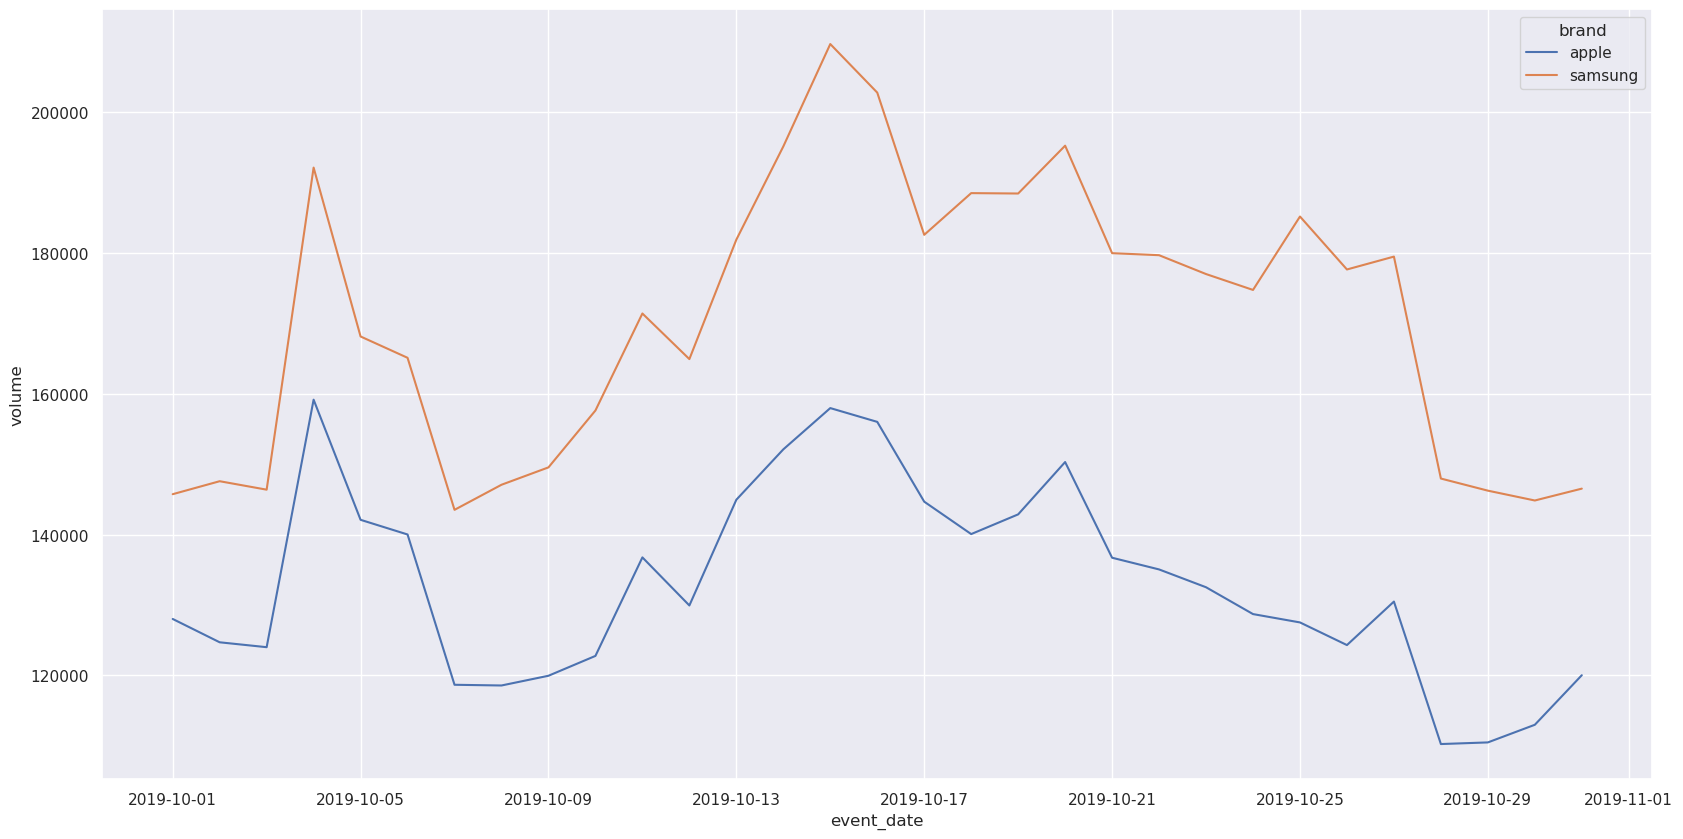

In [25]:
import seaborn as sns
sns.lineplot(apple_vs_samsung,x="event_date",y="volume", hue="brand")
sns.set(rc={'figure.figsize':(30, 10)})

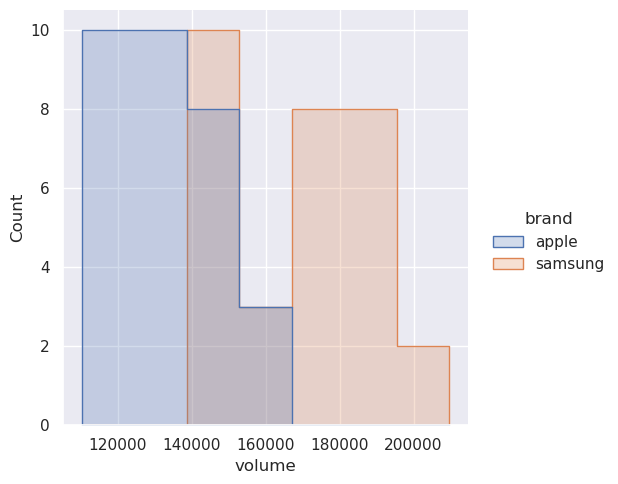

In [26]:
sns.displot(apple_vs_samsung, x="volume", hue="brand", element="step")
sns.set(rc={'figure.figsize':(40,20)})

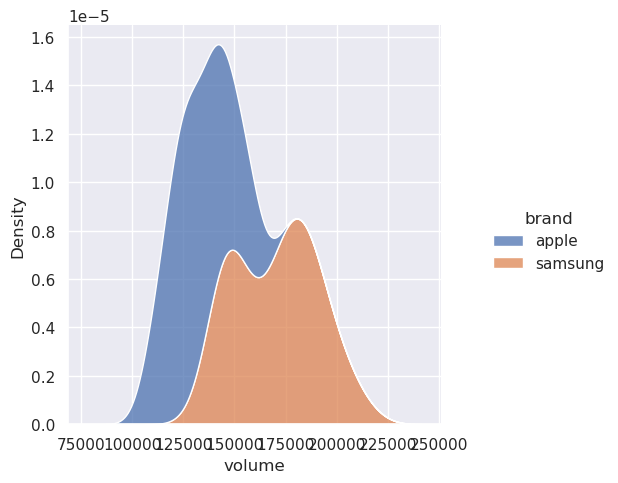

In [27]:
sns.displot(apple_vs_samsung, x="volume", hue="brand", kind='kde', multiple="stack")
sns.set(rc={'figure.figsize':(40,20)})

## 5. Drop External Table

When the external table is dropped, it deletes the schema and does not delete the source data file.

In [28]:
cursor.execute('DROP TABLE customer_behaviour')